## Introduction

This notebook performs a detailed analysis of the financial market data. The goal is to understand the trends, patterns, and relationships within the data to build a predictive model.

## Exploratory Data Analysis (EDA)

In this section, we explore the data using various visualizations to understand its characteristics and identify potential patterns and relationships between variables.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14,5)

## Data Loading and Preprocessing

In this section, we load the dataset and perform initial preprocessing steps. This includes handling missing values, converting data types, and preparing the data for analysis.

In [26]:
# Cell 2 ── Load raw CSV
url = "ai_financial_market_daily_realistic_synthetic.csv"
df  = pd.read_csv(url)

In [27]:
# Cell 3 ── Basic cleaning & type casting
df = df.rename(columns=str.strip)                 # remove accidental spaces
df["Date"] = pd.to_datetime(df["Date"])
num_cols = ["R&D_Spending_USD_Mn", "AI_Revenue_USD_Mn", 
            "AI_Revenue_Growth_%", "Stock_Impact_%"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.sort_values("Date").set_index("Date")
df.head()

,Company,R&D_Spending_USD_Mn,AI_Revenue_USD_Mn,AI_Revenue_Growth_%,Event,Stock_Impact_%
Date,,,,,,
2015-01-01,OpenAI,5.92,0.63,-36.82,NaN,-0.36
2015-01-01,Google,79.89,30.19,0.64,NaN,-0.02
2015-01-01,Meta,50.39,18.95,-5.23,NaN,-0.42
2015-01-02,OpenAI,5.41,1.81,80.59,NaN,0.41
2015-01-02,Google,78.99,30.44,1.47,NaN,-0.98


In [28]:
# Cell 4 ── Quick sanity check
df.info(),
df.describe().T[["mean","std","min","max"]]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10959 entries, 2015-01-01 to 2024-12-31
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              10959 non-null  object 
 1   R&D_Spending_USD_Mn  10959 non-null  float64
 2   AI_Revenue_USD_Mn    10959 non-null  float64
 3   AI_Revenue_Growth_%  10959 non-null  float64
 4   Event                233 non-null    object 
 5   Stock_Impact_%       10959 non-null  float64
dtypes: float64(4), object(2)
memory usage: 599.3+ KB


,mean,std,min,max
R&D_Spending_USD_Mn,65.184504,47.918247,1.57,163.83
AI_Revenue_USD_Mn,44.126571,41.639356,-0.55,155.96
AI_Revenue_Growth_%,159.395988,135.462185,-155.43,565.50
Stock_Impact_%,0.025560,0.749513,-3.00,18.50


## Feature Engineering

This section focuses on creating new features from the existing data to improve the performance of our machine learning model.

In [29]:
# Cell 5 ── Add derived metrics
df["RD_to_AI_ratio"] = df["R&D_Spending_USD_Mn"] / df["AI_Revenue_USD_Mn"].replace(0, np.nan)
df["Month"] = df.index.to_period("M")
monthly = df.groupby("Month").agg({
    "R&D_Spending_USD_Mn":"mean",
    "AI_Revenue_USD_Mn":"mean",
    "AI_Revenue_Growth_%":"mean",
    "Stock_Impact_%":"mean"
}).rename(columns=lambda x: x.replace("_Mn",""))

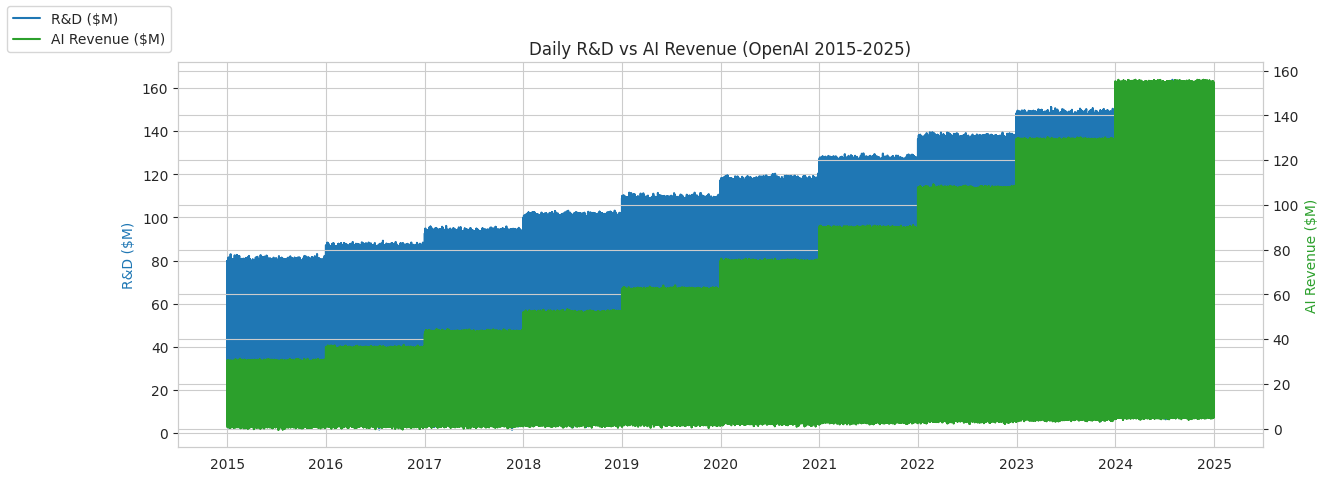

In [30]:
# Cell 6 ── Visual: R&D vs AI Revenue over time
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df.index, df["R&D_Spending_USD_Mn"], color="tab:blue", label="R&D ($M)")
ax2.plot(df.index, df["AI_Revenue_USD_Mn"], color="tab:green", label="AI Revenue ($M)")
ax.set_ylabel("R&D ($M)", color="tab:blue")
ax2.set_ylabel("AI Revenue ($M)", color="tab:green")
ax.set_title("Daily R&D vs AI Revenue (OpenAI 2015-2025)")
fig.legend(loc="upper left")
plt.show()

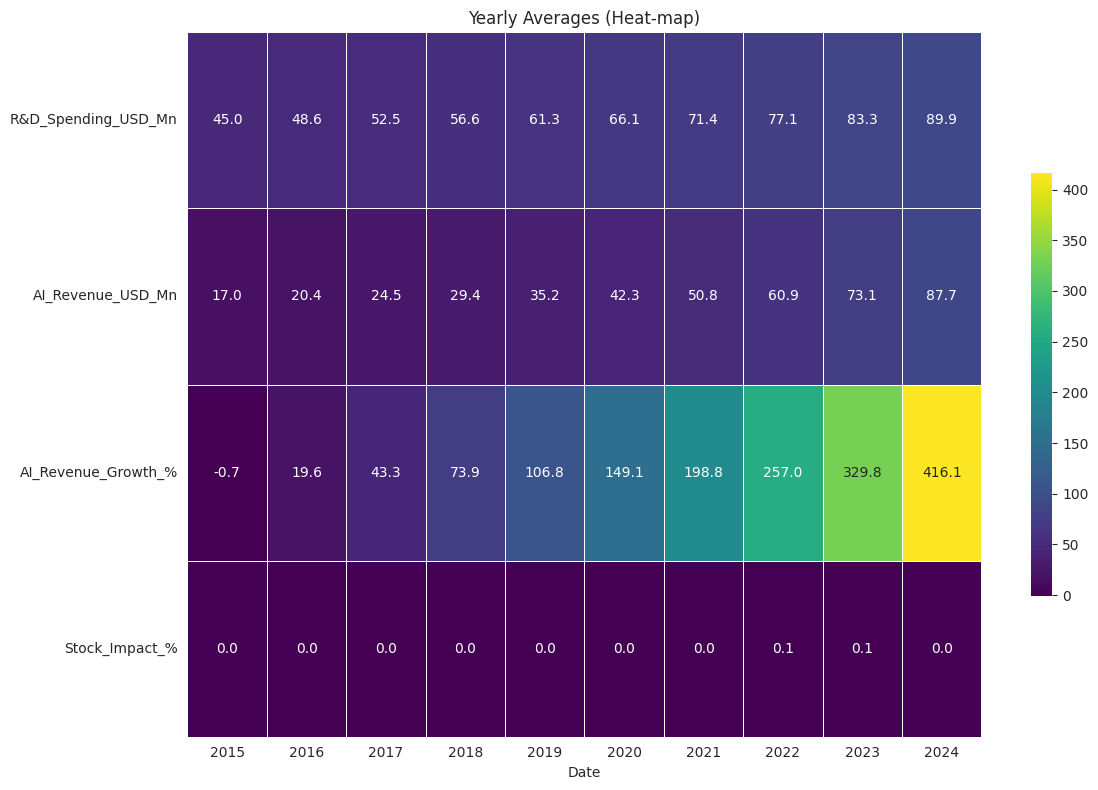

In [31]:
# Cell 7 ── Cleaner 12-month rolling heat-map
# resample to yearly to reduce clutter
yearly = df.groupby(df.index.year)[["R&D_Spending_USD_Mn",
                                    "AI_Revenue_USD_Mn",
                                    "AI_Revenue_Growth_%",
                                    "Stock_Impact_%"]].mean()

plt.figure(figsize=(12,8))
sns.heatmap(yearly.T,
            annot=True,
            fmt=".1f",
            cmap="viridis",
            linewidths=.5,
            cbar_kws={"shrink": .6})
plt.title("Yearly Averages (Heat-map)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
# Cell 8 ── Events & stock impact  (FIXED)
events = df[df["Event"].notna()].reset_index()   # bring Date back as a column
fig = px.scatter(events, x="AI_Revenue_Growth_%", y="Stock_Impact_%",
                 color="Event", hover_data=["Date"], size="AI_Revenue_USD_Mn",
                 title="Stock Impact vs Revenue Growth on Major Events")
fig.show()

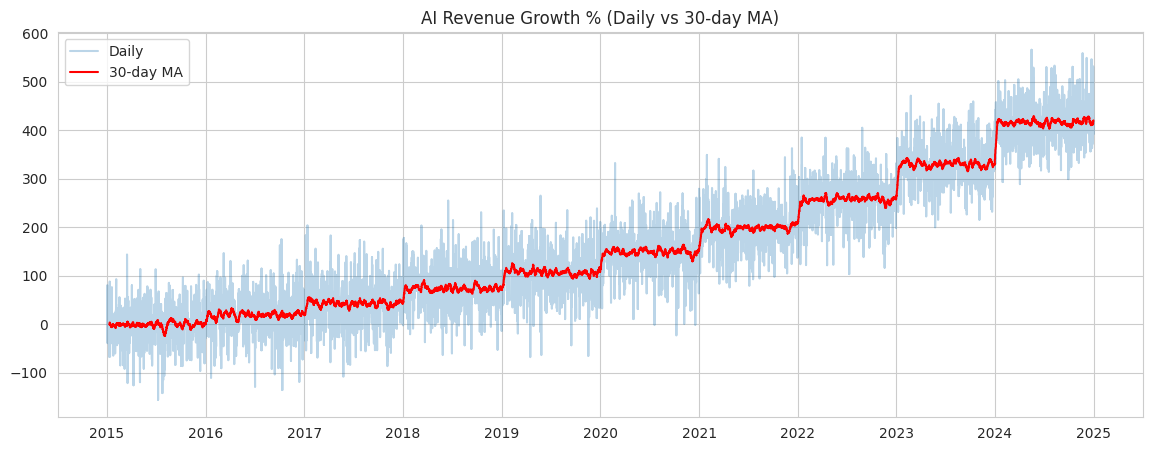

In [33]:
# Cell 9 ── Growth trend with 30-day rolling mean
df["AI_Revenue_Growth_30d"] = df["AI_Revenue_Growth_%"].rolling(30).mean()
plt.figure()
plt.plot(df.index, df["AI_Revenue_Growth_%"], alpha=.3, label="Daily")
plt.plot(df.index, df["AI_Revenue_Growth_30d"], color="red", label="30-day MA")
plt.title("AI Revenue Growth % (Daily vs 30-day MA)")
plt.legend(); plt.show()

## Model Training

Here, we train a machine learning model on the prepared data. We will use a Prophet model for time series forecasting.

## Forecasting

In this section, we use the trained model to make predictions on future data points.

/tmp/ipykernel_142719/2118589447.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

DEBUG	Task(Task-3) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: /tmp/tmpxn7broii/dcjfroq_.json
DEBUG	Task(Task-3) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: /tmp/tmpxn7broii/o8cg0mbp.json
DEBUG	Task(Task-3) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-3) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-3) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['/home/ayyan/jupyter_venv/jupyter_venv/lib/python3.13/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26010', 'data', 'file=/tmp/tmpxn7broii/dcjfroq_.json', 'init=/tmp/tmpxn7broii/o8cg0mbp.json', 'output', 'file=/tmp/tmpxn7broii/prophet_modelvbp3d_3i/prophet_model-20250816174917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:17 - cmdstanpy - INFO - Chain [1] start processing
INFO

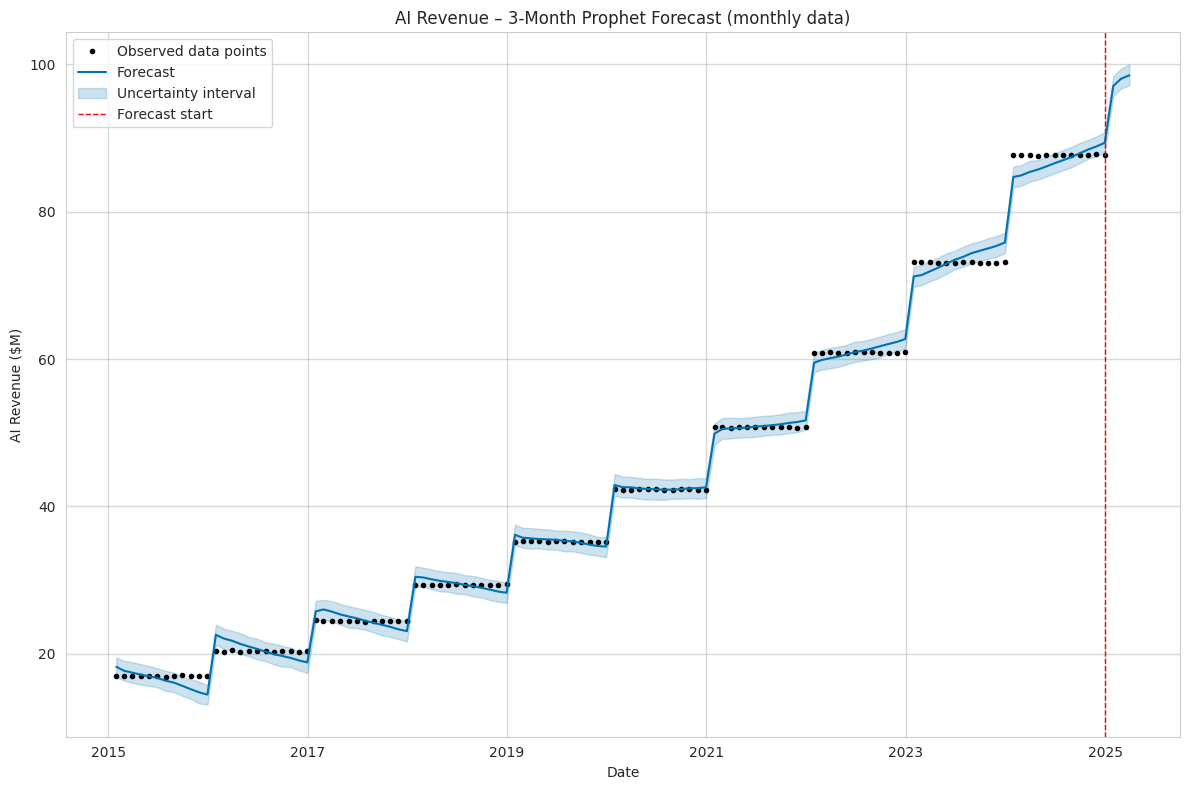

In [35]:
# Cell 10 ── Cleaner Prophet forecast with readable labels
from prophet import Prophet

# Monthly aggregation to reduce noise
prop = (df["AI_Revenue_USD_Mn"]
        .resample("M")
        .mean()
        .dropna()
        .reset_index()
        .rename(columns={"Date": "ds", "AI_Revenue_USD_Mn": "y"}))

m = Prophet(daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=True)
m.fit(prop)

future = m.make_future_dataframe(periods=3, freq="ME")
fcst = m.predict(future)

fig, ax = plt.subplots(figsize=(12, 8))
m.plot(fcst, ax=ax)

# --- extra labels ---
ax.set_title("AI Revenue – 3-Month Prophet Forecast (monthly data)")
ax.set_xlabel("Date")
ax.set_ylabel("AI Revenue ($M)")
ax.grid(alpha=0.3)

# highlight the forecast region
ax.axvline(prop["ds"].max(), color="red", ls="--", lw=1, label="Forecast start")
ax.legend()

plt.tight_layout()
plt.show()

## Conclusion

This notebook presented a comprehensive analysis of the financial market data, from data loading and preprocessing to model training and forecasting. The results of our analysis and the performance of the model are summarized in this notebook.